In [1]:
import pandas as pd
import numpy as np
from pandas_datareader import data as pdr
import datetime as dt
import matplotlib.pyplot as plt
import yfinance as yf

In [2]:
#Data collection
start = dt.datetime(2019,1,1)
end =  dt.datetime.now()
df = yf.download("^BSESN", start, end, interval="1wk")

[*********************100%***********************]  1 of 1 completed


In [3]:
df.to_csv('sensex.csv')

In [4]:
DF = pd.read_csv('sensex.csv')

In [5]:
DF.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-12-31,36198.128906,36236.699219,35382.078125,35695.101562,35695.101562,30578400
1,2019-01-07,35971.179688,36269.308594,35753.949219,36009.839844,36009.839844,48419100
2,2019-01-14,36113.269531,36469.980469,35691.750000,36386.609375,36386.609375,105800
3,2019-01-21,36467.121094,36701.031250,35953.148438,36025.539062,36025.539062,96400
4,2019-01-28,36099.621094,36778.140625,35375.511719,36469.429688,36469.429688,86086000


In [6]:
data = DF.reset_index()['Close']

In [7]:
data.shape

(134,)

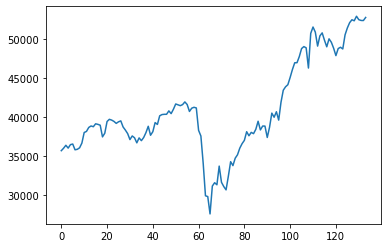

In [8]:
plt.plot(data)

since LSTM is being used in this project, I'm going to use MinMax scaler cause LSTM is highly sensitive to the scale of data

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(np.array(data).reshape(-1, 1))

In [10]:
data.shape

(134, 1)

Splitting dataset into train and test set

In [11]:
train_size = int(len(data)*0.7)
train_set, test_set = data[0:train_size, :], data[train_size:len(data), :1]

In [12]:
## converting the array of values into dataset matrices(x & y)
import numpy
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i+time_step])
    return numpy.array(dataX), numpy.array(dataY)      

In [13]:
##reshaping the data
time_step = 3
x_train, y_train = create_dataset(train_set, time_step)
x_test, y_test = create_dataset(test_set, time_step)

In [14]:
##reshaping the data to feed into a stacked LSTM [samples, time_steps, features]
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

Creating the stacked LSTM model

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [16]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(3, 1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 3, 50)             10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 3, 50)             20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [18]:
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50, batch_size=8, verbose=1)

Epoch 1/50
12/12 [==============================] - 3s 62ms/step - loss: 0.1281 - val_loss: 0.4372
Epoch 2/50
12/12 [==============================] - 0s 4ms/step - loss: 0.0324 - val_loss: 0.0494
Epoch 3/50
12/12 [==============================] - 0s 4ms/step - loss: 0.0143 - val_loss: 0.1403
Epoch 4/50
12/12 [==============================] - 0s 11ms/step - loss: 0.0107 - val_loss: 0.1251
Epoch 5/50
12/12 [==============================] - 0s 4ms/step - loss: 0.0089 - val_loss: 0.0901
Epoch 6/50
12/12 [==============================] - 0s 5ms/step - loss: 0.0085 - val_loss: 0.0915
Epoch 7/50
12/12 [==============================] - 0s 4ms/step - loss: 0.0078 - val_loss: 0.0763
Epoch 8/50
12/12 [==============================] - 0s 4ms/step - loss: 0.0073 - val_loss: 0.0708
Epoch 9/50
12/12 [==============================] - 0s 4ms/step - loss: 0.0063 - val_loss: 0.0298
Epoch 10/50
12/12 [==============================] - 0s 4ms/step - loss: 0.0063 - val_loss: 0.0364
Epoch 11/50
12/12

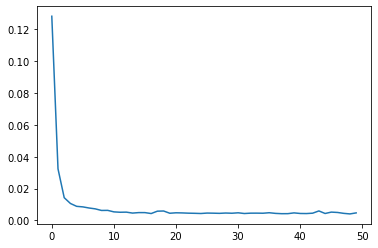

In [19]:
loss_per_epochs = model.history.history['loss']
plt.plot(range(len(loss_per_epochs)), loss_per_epochs)

In [20]:
import tensorflow as tf

In [21]:
### making predictions and checking performance matrices
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

In [22]:
###inverse_transforming the data to it's original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [23]:
###calculating the rmse score of performance matrices
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train, train_predict))

38024.95229381938

In [24]:
math.sqrt(mean_squared_error(y_test, test_predict))

50028.75268935667

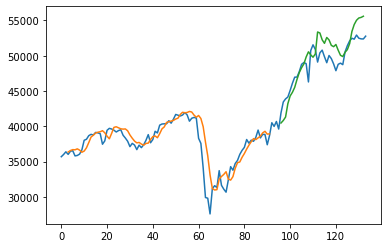

In [25]:
###plotting
# shift train predictions for plotting
look_back = 3
trainPredictPlot = numpy.empty_like(data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test prediction for plotting
testPredictPlot = numpy.empty_like(data)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(data)-1, :] = test_predict
#plotting baseline and predictions
plt.plot(scaler.inverse_transform(data))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

Prediction for next 30 days

In [26]:
x_input = test_set[len(test_set)-3: ].reshape(1, -1)
x_input.shape

(1, 3)

In [27]:
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

In [28]:
##predicting the data
from numpy import array
lst_output = []
n_steps = 3
i = 0
while(i<30):
    if(len(temp_input)>3):
        x_input = np.array(temp_input[1:])
        print("{} Day input {}".format(i, x_input))
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape(1, n_steps, 1)
        yhat = model.predict(x_input, verbose=0)
        print("{} Day output {}".format(i, yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i = i+1
    else:
        x_input = x_input.reshape(1, n_steps, 1)
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i = i+1
print(lst_output)

[1.0920848]
4
1 Day input [0.97819745 0.99386958 1.09208477]
1 Day output [[1.1206553]]
2 Day input [0.99386958 1.09208477 1.1206553 ]
2 Day output [[1.1845821]]
3 Day input [1.09208477 1.1206553  1.18458211]
3 Day output [[1.2818655]]
4 Day input [1.1206553  1.18458211 1.28186548]
4 Day output [[1.356326]]
5 Day input [1.18458211 1.28186548 1.35632598]
5 Day output [[1.4688457]]
6 Day input [1.28186548 1.35632598 1.46884573]
6 Day output [[1.6048248]]
7 Day input [1.35632598 1.46884573 1.60482478]
7 Day output [[1.7500288]]
8 Day input [1.46884573 1.60482478 1.75002885]
8 Day output [[1.9375646]]
9 Day input [1.60482478 1.75002885 1.93756461]
9 Day output [[2.1542501]]
10 Day input [1.75002885 1.93756461 2.15425014]
10 Day output [[2.3976836]]
11 Day input [1.93756461 2.15425014 2.39768362]
11 Day output [[2.6755395]]
12 Day input [2.15425014 2.39768362 2.67553949]
12 Day output [[2.966757]]
13 Day input [2.39768362 2.67553949 2.96675706]
13 Day output [[3.2571068]]
14 Day input [2.67

In [29]:
day_new = np.arange(1,4)
day_pred = np.arange(4,34)

In [30]:
len(data)

134

In [31]:
data1 = data.tolist()
data1.extend(lst_output)

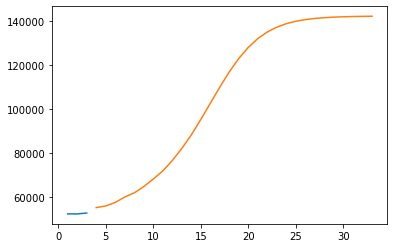

In [32]:
plt.plot(day_new, scaler.inverse_transform(data[(len(data)-3):]))
plt.plot(day_pred, scaler.inverse_transform(lst_output))

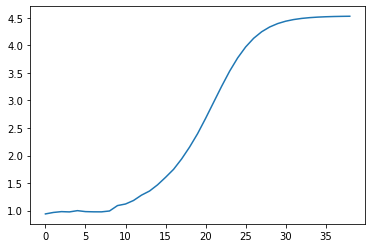

In [34]:
data1 = data.tolist()
data1.extend(lst_output)
plt.plot(data1[125:])